In [2]:
!cp /kaggle/input/nn-utils/* .

In [ ]:
#!cp /kaggle/input/kaggle-nn-v1-train-1/model.keras .
#!wget https://minecraft-mods.4lima.de/model.keras
!cp /kaggle/input/nn-train-v2/model.weights.h5 .

In [3]:
!pip install tensorflow==2.18.0 keras h5py keras==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have te

In [3]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

#candles = obj_load("/content/NQ_2")[-100000:]
candles = obj_load("/kaggle/input/us-futures-1-minute-candlesticks/NQ_1")#[50000:]
len(candles)

loading /kaggle/input/us-futures-1-minute-candlesticks/NQ_1


99990

In [4]:
#model = tf.keras.models.load_model("model.keras", safe_mode=False, compile=False)
#model.summary()

In [5]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(64)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(32)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(64)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(64)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(32)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(64)(m1_at)

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, m1_at, m5_at])


d = tf.keras.layers.Dense(128)(c)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(128)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(128)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)




output = tf.keras.layers.Dense(3, activation="softmax", dtype="float32")(d)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0)


model.summary()


# In[10]:



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 94)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 60, 94)         │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 60, 98)         │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 60, 64)         │          6,336 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128)            │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0],         │
│                           │                        │                │ dense_4[0][0],         │
│                           │                        │                │ dense_5[0][0],         │
│                           │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 60, 98)         │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 60, 32)         │          2,080 │ leaky_re_lu[2][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 60, 64)         │          6,336 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 60, 32)         │          2,080 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 60, 4)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)

 Total params: 233,155 (910.76 KB)

 Trainable params: 233,155 (910.76 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.load_weights("model.weights.h5")

In [6]:

class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction

In [7]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

              
                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 2):
                #equity += open_profit
                #current_position = Position(0,0,0,0)
                #print("close position:", open_profit)
                current_order = None

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    #sl = sorted_by_low[2][1]
                    tp = entry  -  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, -1)
                        #print("set short order:",entry,sl,tp)
                    if current_position.direction == -1:
                        #current_position.sl = sl
                        current_position.tp = tp



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    #sl = sorted_by_high[2][0]
                    tp = entry  +  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, 1)
                        #print("set long order:",entry,sl,tp)
                    if current_position.direction == 1:
                        #current_position.sl = sl
                        current_position.tp = tp
                        



In [8]:
m = MultiTimeframeCandleManager()

slm = 3
#tpm = 6
tpm = 3


current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print("\n", equity_L[-1])

print(equity_L[-1])

  4%|▍         | 4070/99990 [00:00<00:05, 19006.64it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0.0

 0.0

 0.0

 0.0

 0.0

 0.0

 0.0

 0.0

 0.0

 0.0

 105.23749999999927

 148.98749999999927

 104.98749999999927

 231.47499999999854


  6%|▌         | 5993/99990 [00:12<04:29, 348.31it/s]  


 231.47499999999854

 231.47499999999854

 224.21249999999782

 245.71249999999782

 177.23749999999927

 180.61249999999927

 244.79999999999927

 244.79999999999927

 244.79999999999927

 218.53750000000218

 -87.0374999999949


  7%|▋         | 7035/99990 [00:21<07:20, 210.85it/s]


 17.462500000005093

 48.21250000000509

 99.28750000000582

 109.91250000000582

 71.98750000000655

 68.23750000000655


  8%|▊         | 7670/99990 [00:26<08:31, 180.66it/s]


 31.80000000000655

 40.78750000000582

 21.73750000000655

 21.73750000000655


  8%|▊         | 8081/99990 [00:30<09:10, 166.82it/s]


 21.73750000000655

 21.73750000000655

 21.73750000000655


  8%|▊         | 8356/99990 [00:32<09:36, 158.89it/s]


 21.73750000000655

 21.73750000000655


  9%|▊         | 8546/99990 [00:33<09:59, 152.57it/s]


 21.73750000000655


  9%|▊         | 8679/99990 [00:35<10:13, 148.88it/s]


 21.73750000000655


  9%|▉         | 8775/99990 [00:35<10:26, 145.57it/s]


 21.73750000000655


  9%|▉         | 8897/99990 [00:36<10:47, 140.75it/s]


 21.73750000000655


  9%|▉         | 9017/99990 [00:37<11:18, 134.03it/s]


 21.73750000000655


  9%|▉         | 9125/99990 [00:38<12:08, 124.76it/s]


 21.73750000000655


  9%|▉         | 9215/99990 [00:39<12:37, 119.78it/s]


 21.73750000000655


  9%|▉         | 9313/99990 [00:40<12:37, 119.77it/s]


 21.73750000000655


  9%|▉         | 9413/99990 [00:41<12:36, 119.68it/s]


 21.73750000000655


 10%|▉         | 9514/99990 [00:41<12:56, 116.51it/s]


 21.73750000000655


 10%|▉         | 9614/99990 [00:42<12:38, 119.18it/s]


 21.73750000000655


 10%|▉         | 9714/99990 [00:43<12:47, 117.57it/s]


 21.73750000000655


 10%|▉         | 9818/99990 [00:44<12:34, 119.56it/s]


 21.73750000000655


 10%|▉         | 9919/99990 [00:45<06:51, 218.68it/s]


 21.73750000000655


KeyboardInterrupt: 

0 21.73750000000655


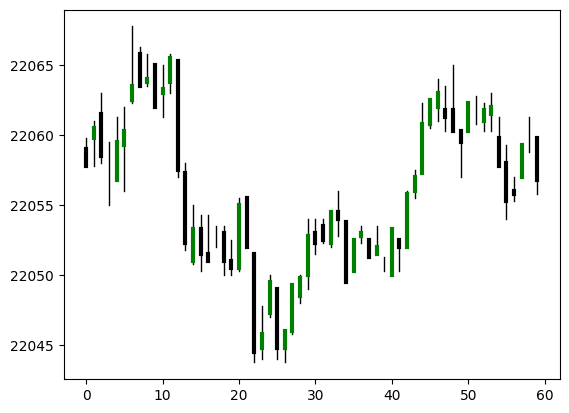

In [9]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
#step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

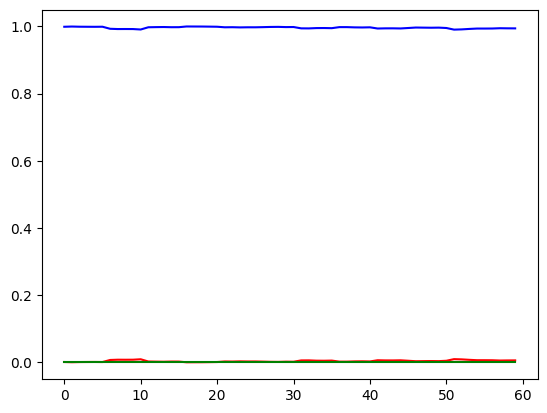

In [10]:
#plt.plot(outputs)
plt.plot([x[0] for x in outputs[-60:]], color="r")
plt.plot([x[1] for x in outputs[-60:]], color="g")
plt.plot([x[2] for x in outputs[-60:]], color="b")

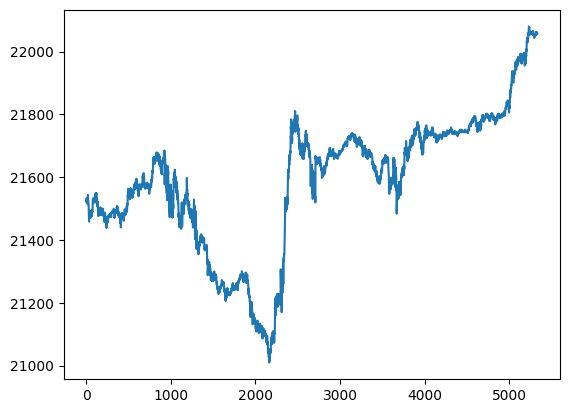

In [11]:
plt.plot([x.c for x in all_candles])

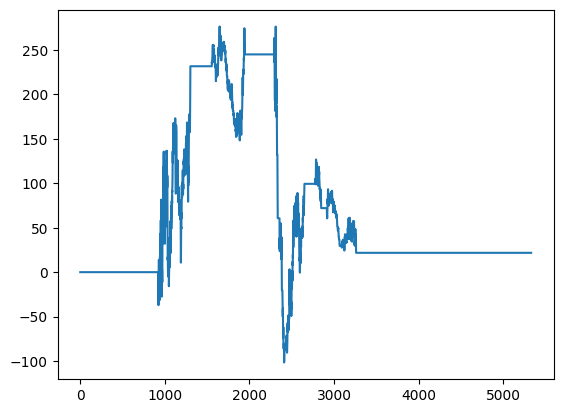

In [12]:
plt.plot(equity_L)

In [ ]:
#plt.plot([x[1]-x[0] for x in outputs], color="b")